# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-7]
regularization_strengths = [5e4, 5e6]

results = {}
best_val = -1
best_svm = None

range_lr = np.linspace(learning_rates[0],learning_rates[1],20)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],20)
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for valid_lr in range_lr:
    for valid_reg in range_reg:
        
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, valid_lr, valid_reg, num_iters=3000)
        
        train_predict = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == train_predict)
        
        val_predict = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == val_predict)
        
        results[(valid_lr,valid_reg)] = (train_accuracy,val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.093571 val accuracy: 0.097000
lr 1.000000e-09 reg 6.000000e+05 train accuracy: 0.105735 val accuracy: 0.119000
lr 1.000000e-09 reg 1.150000e+06 train accuracy: 0.135327 val accuracy: 0.134000
lr 1.000000e-09 reg 1.700000e+06 train accuracy: 0.404959 val accuracy: 0.402000
lr 1.000000e-09 reg 2.250000e+06 train accuracy: 0.415490 val accuracy: 0.422000
lr 1.000000e-09 reg 2.800000e+06 train accuracy: 0.413857 val accuracy: 0.414000
lr 1.000000e-09 reg 3.350000e+06 train accuracy: 0.414531 val accuracy: 0.418000
lr 1.000000e-09 reg 3.900000e+06 train accuracy: 0.414816 val accuracy: 0.413000
lr 1.000000e-09 reg 4.450000e+06 train accuracy: 0.414306 val accuracy: 0.422000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.414980 val accuracy: 0.417000
lr 1.200000e-08 reg 5.000000e+04 train accuracy: 0.120184 val accuracy: 0.102000
lr 1.200000e-08 reg 6.000000e+05 train accuracy: 0.416694 val accuracy: 0.407000
lr 1.200000e-08 reg 1.150000

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.414


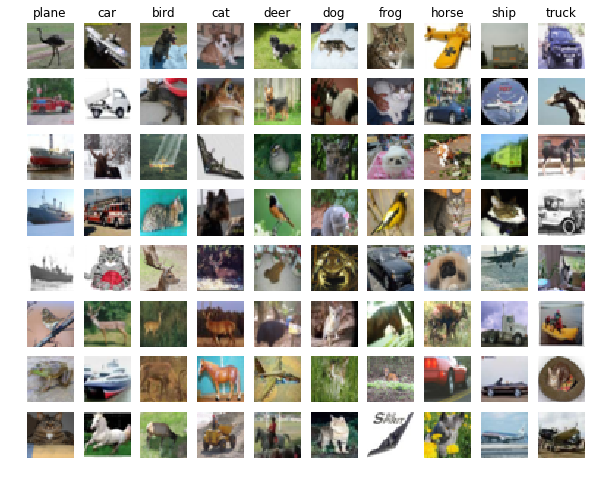

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

The color histogram feature brings a bias towards images with similar backgrounds or foregrounds as the same class, which leads a kind of misclassification. For example, the bird and the hourse in green background are misclassified to frog. Similarly, the HOG feature trends to put images with similar edges into the same category. For example, many cars are misclassified to truck. Hence, the misclassification results make sense.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print(X_train_feats.shape)

(49000, 155)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet
import time

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val_acc = -1
# hidden_size = [75, 150]
learning_rates = [1e-2, 2e0]
regularization_strengths = [1e-3, 2e-2]

range_lr = np.linspace(learning_rates[0],learning_rates[1],5)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],5)
# range_hs = np.linspace(hidden_size[0],hidden_size[1],4, dtype = int)

rate = 0
# for hs in range_hs:
    
for lr in range_lr:
    tic = time.time()
    for reg in range_reg:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=1500, batch_size=400, learning_rate=lr, 
        learning_rate_decay=0.95, reg = reg)
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net         
        results[(lr,reg)] = val_acc
    rate += 0.2
    toc = time.time()
    print(rate,"% done", toc-tic, "seconds costed")

for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print( "lr {} reg {} val accuracy:{}".format(lr, reg, val_acc) )
    
print("Best validation accuracy:{}".format(best_val_acc))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

0.2 % done 39.82593655586243 seconds costed
0.4 % done 36.19486713409424 seconds costed
0.6000000000000001 % done 38.62252497673035 seconds costed
0.8 % done 37.73517084121704 seconds costed
1.0 % done 38.082823514938354 seconds costed
lr 0.01 reg 0.001 val accuracy:0.169
lr 0.01 reg 0.00575 val accuracy:0.119
lr 0.01 reg 0.010499999999999999 val accuracy:0.196
lr 0.01 reg 0.01525 val accuracy:0.158
lr 0.01 reg 0.02 val accuracy:0.188
lr 0.5075 reg 0.001 val accuracy:0.587
lr 0.5075 reg 0.00575 val accuracy:0.554
lr 0.5075 reg 0.010499999999999999 val accuracy:0.519
lr 0.5075 reg 0.01525 val accuracy:0.494
lr 0.5075 reg 0.02 val accuracy:0.5
lr 1.005 reg 0.001 val accuracy:0.607
lr 1.005 reg 0.00575 val accuracy:0.547
lr 1.005 reg 0.010499999999999999 val accuracy:0.502
lr 1.005 reg 0.01525 val accuracy:0.508
lr 1.005 reg 0.02 val accuracy:0.484
lr 1.5025 reg 0.001 val accuracy:0.572
lr 1.5025 reg 0.00575 val accuracy:0.502
lr 1.5025 reg 0.010499999999999999 val accuracy:0.481
lr 1.502

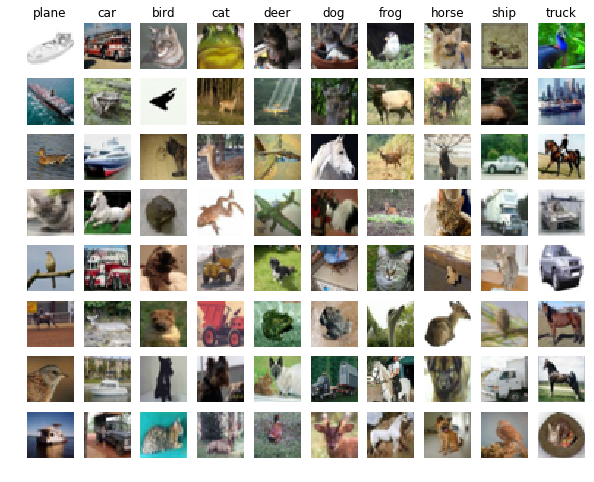

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [11]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.581


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

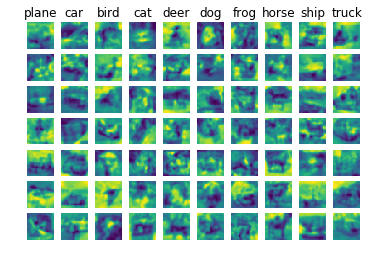

In [32]:
## For convenience, I'd like to use the build-in Sobel filter to help me extracting the edge feature.
from scipy import ndimage
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from cs231n.features import *

cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

def catch_edge(imgs):
    imgs = rgb2gray(imgs)
    imgs = ndimage.gaussian_filter(imgs, 1, mode = "reflect", truncate=3.0)
    fil_img = ndimage.gaussian_filter(imgs, 0.1, mode = "reflect", truncate=3.0)
    shapen = fil_img + 10*np.abs(fil_img - imgs)
    return shapen
    feature_x = ndimage.sobel(imgs, axis=0, mode = "constant")
    feature_y = ndimage.sobel(imgs, axis=1, mode = "constant")
    return np.hypot(feature_x, feature_y)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
X_train = catch_edge(X_train)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!